In [1]:
import sys
sys.path.append('../code')
from resnet import *
from cifar_very_tiny import *
from cifar_dataset import *    
import torch as t 
import numpy as np
from numpy import polyfit
from numpy import polyval
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from scipy.interpolate import interp1d
%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [2]:
# добавил в загрузку валидационную выборку
# обрати внимание, maxsize --- это размер совокпного обучения и валидации
# поэтому размер обучающей выборки совпадает с тем, что было до этого
_, test_loader, train_loader_no_augumentation, valid_loader = cifar10_loader(batch_size=128, split_train_val=True,
                                                                             maxsize=10112*2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch_num = 100
# epoch_num = 50
run_num = 5 # количество запусков эксперимента
# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '18' 

validate_every_epoch = 5 
# spline_mode = 'linear' #полиномом какой степени пользуемся, смотри функцию scipy.interpolate.interp1d
# spline_mode = 'quadratic'
# spline_mode = 'cubic'
# train_splines_every_epoch = 5 # каждые 5 эпох отслеживать траекторию гиперпараметров
train_splines_every_epoch = 2
# train_splines_every_epoch = 3
# train_splines_every_epoch = 10
# размер мини-эпохи в батчах, за которую у нас производится либо обучение спайлов, либо их использование
mini_epoch_size = 10 

In [4]:
def accuracy(student):
        student.eval()
        total = 0 
        correct = 0
        with t.no_grad():
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)
                out = student(x)
                correct += t.eq(t.argmax(out, 1), y).sum()
                total+=len(x)
        student.train()
        return (correct/total).cpu().detach().numpy()

In [5]:
kl = nn.KLDivLoss(reduction='batchmean')
sm = nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = F.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [8]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-beta
crit = nn.CrossEntropyLoss()

# определяем функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 9.9 + 0.1
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

# определяем функцию валидационную функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

hist = []
logits = np.load('../code/logits_cnn.npy')
for _ in range(run_num):
    internal_results = []    
    # теперь beta и temp - не числа, а тензоры, по которым можно считать градиент
    beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1), device=device), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0), device=device), requires_grad=True)    
    h = [beta1, beta2, temp]
    
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    
    # параметры Adam и функцию подсчета градиента 
    # взял из статьи по DARTS (выбор архитектуры сети градиентными методами)
    # там также используется оптимизация гиперпараметров
    optim2 = t.optim.SGD(h,  10e4)   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    
    crit = t.nn.CrossEntropyLoss()

    for e in range(epoch_num): # хочется посмотреть куда сойдутся гиперпараметры, поэтому возьмем побольше эпох
        
        
        tq = tqdm.tqdm(zip(train_loader_no_augumentation, valid_loader))
        losses = []
        for batch_id, ((x,y), (v_x, v_y)) in enumerate(tq):
            mini_e = batch_id // mini_epoch_size
            
            if mini_e % train_splines_every_epoch == 0 and batch_id % mini_epoch_size  == 0:                
                spline_hist = []
                spline_id  = -1 
                #print (batch_id, 'start mini')

            spline_id += 1
            x = x.to(device)
            y = y.to(device)            
                      
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device) 
            # если настала пора понаблюдать за траекторий гиперпараметров
            if mini_e % train_splines_every_epoch == 0:
                #print (batch_id, 'train mini')
                v_x = v_x.to(device)
                v_y = v_y.to(device)  
                optim2.zero_grad()            
                hyper_grad_calc.calc_gradients((x,y,batch_logits), (v_x, v_y))            
                t.nn.utils.clip_grad_value_(h, 1.0)
                for h_ in h:
                    h_.grad = t.where(t.isnan(h_.grad), t.zeros_like(h_.grad), h_.grad) 
                optim2.step()                
                spline_hist.append([h_.cpu().detach().clone().numpy()  for h_ in h])
            else:
                #print (batch_id, 'infer mini')
                spline_out = splines(spline_id)                
                beta1.data *= 0
                beta2.data *= 0
                temp.data *= 0
                
                beta1.data += spline_out[0]
                beta2.data += spline_out[1]
                temp.data += spline_out[2]
                
            hist.append([h_.grad.cpu().detach().clone().numpy()  for h_ in h])
            optim.zero_grad()
            loss = param_loss((x,y,batch_logits), student,h)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        
        # если мы отслеживали траекторию эпохи - можно обучить на этом сплайны
            if mini_e % train_splines_every_epoch == 0 and batch_id%mini_epoch_size == mini_epoch_size-1:
                fitted1 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,0], 1)
                fitted2 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,1], 1)
                fitted3 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,2], 1)
                splines = lambda x : np.array([np.polyval(fitted1, x), np.polyval(fitted2, x), np.polyval(fitted3, x)])

        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            test_loss2 = []            
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss2.append(crit(student(x), y).detach().cpu().numpy())                 
            print (float(np.mean(test_loss2)))
            
            
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc, 
                                     'temp':float(0.1+9.9*F.sigmoid(h[2]).cpu().detach().numpy()),
                                     'beta1':float(F.sigmoid(h[0]).cpu().detach().numpy()),
                                     'beta2':float(F.sigmoid(h[1]).cpu().detach().numpy())})
            
            print (internal_results[-1])

            
    with open('exp'+experiment_version+'_dist_h_b2_splines.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

0it [00:00, ?it/s]<ipython-input-5-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:1.775704026222229: : 79it [00:04, 18.52it/s] 


1.6641250848770142


current loss:1.6690903902053833: : 2it [00:00, 16.90it/s]

{'epoch': 0, 'test loss': 1.6641992330551147, 'accuracy': 0.37199997901916504, 'temp': 1.59295913875103, 'beta1': 0.2986242473125458, 'beta2': 0.41592955589294434}


current loss:1.5576294660568237: : 79it [00:04, 18.97it/s]
current loss:1.4536138772964478: : 79it [00:04, 19.23it/s]
current loss:1.3715870380401611: : 79it [00:04, 18.82it/s]
current loss:1.3280295133590698: : 79it [00:04, 18.67it/s]


1.4621983766555786


current loss:1.2755945920944214: : 2it [00:00, 16.99it/s]

{'epoch': 4, 'test loss': 1.4623730182647705, 'accuracy': 0.5178999900817871, 'temp': 1.3499037548899653, 'beta1': 0.31707412004470825, 'beta2': 0.44980520009994507}


current loss:1.3137949705123901: : 79it [00:04, 18.69it/s]
current loss:1.3113899230957031: : 79it [00:04, 18.98it/s]
current loss:1.311570405960083: : 79it [00:04, 18.84it/s] 
current loss:1.3262932300567627: : 79it [00:04, 18.82it/s]
current loss:1.3507198095321655: : 79it [00:04, 18.80it/s]


1.5108797550201416


current loss:1.3046122789382935: : 2it [00:00, 17.03it/s]

{'epoch': 9, 'test loss': 1.5101383924484253, 'accuracy': 0.5356999635696411, 'temp': 0.9443607456982136, 'beta1': 0.35861870646476746, 'beta2': 0.4827401340007782}


current loss:1.367671012878418: : 79it [00:04, 19.20it/s] 
current loss:1.456634759902954: : 79it [00:04, 18.57it/s] 
current loss:1.5844231843948364: : 79it [00:04, 18.53it/s]
current loss:1.8848788738250732: : 79it [00:04, 18.83it/s]
current loss:3.3557982444763184: : 79it [00:04, 19.10it/s]


1.67913818359375


current loss:3.140965461730957: : 2it [00:00, 17.21it/s] 

{'epoch': 14, 'test loss': 1.6821733713150024, 'accuracy': 0.530299961566925, 'temp': 0.38221640326082706, 'beta1': 0.5290820598602295, 'beta2': 0.5182034373283386}


current loss:7.6074724197387695: : 79it [00:04, 19.00it/s]
current loss:20.021360397338867: : 79it [00:04, 19.28it/s]
current loss:20.23819923400879: : 79it [00:04, 19.21it/s] 
current loss:24.735036849975586: : 79it [00:04, 18.77it/s]
current loss:24.319305419921875: : 79it [00:04, 18.75it/s]


2.215458631515503


current loss:25.251272201538086: : 2it [00:00, 16.54it/s]

{'epoch': 19, 'test loss': 2.2081265449523926, 'accuracy': 0.4642999768257141, 'temp': 0.10766282488475554, 'beta1': 0.9381976127624512, 'beta2': 0.5998232960700989}


current loss:24.41813087463379: : 79it [00:04, 18.62it/s] 
current loss:25.54922866821289: : 79it [00:04, 18.87it/s] 
current loss:22.16935920715332: : 79it [00:04, 18.82it/s] 
current loss:20.371990203857422: : 79it [00:04, 18.82it/s]
current loss:20.214122772216797: : 79it [00:04, 18.88it/s]


1.8007339239120483


current loss:19.391151428222656: : 2it [00:00, 16.90it/s]

{'epoch': 24, 'test loss': 1.7936017513275146, 'accuracy': 0.5317999720573425, 'temp': 0.10239120531477966, 'beta1': 0.9779912829399109, 'beta2': 0.6763611435890198}


current loss:22.12557029724121: : 79it [00:04, 18.95it/s] 
current loss:17.594287872314453: : 79it [00:04, 18.49it/s]
current loss:17.706218719482422: : 79it [00:04, 18.00it/s]
current loss:19.713741302490234: : 79it [00:04, 18.22it/s]
current loss:17.865039825439453: : 79it [00:04, 18.42it/s]


1.62791109085083


current loss:17.342451095581055: : 2it [00:00, 15.93it/s]

{'epoch': 29, 'test loss': 1.633925437927246, 'accuracy': 0.5582000017166138, 'temp': 0.10177068927732763, 'beta1': 0.9837611317634583, 'beta2': 0.7141577005386353}


current loss:17.770845413208008: : 79it [00:04, 18.11it/s]
current loss:17.178611755371094: : 79it [00:04, 18.56it/s]
current loss:18.188365936279297: : 79it [00:04, 18.53it/s]
current loss:17.217517852783203: : 79it [00:04, 18.28it/s]
current loss:16.507959365844727: : 79it [00:04, 18.39it/s]


1.5892016887664795


current loss:14.743693351745605: : 2it [00:00, 16.63it/s]

{'epoch': 34, 'test loss': 1.5784536600112915, 'accuracy': 0.5586999654769897, 'temp': 0.10134150098456303, 'beta1': 0.9874833822250366, 'beta2': 0.7457674145698547}


current loss:15.758537292480469: : 79it [00:04, 18.58it/s]
current loss:13.946660995483398: : 79it [00:04, 18.71it/s]
current loss:15.103273391723633: : 79it [00:04, 18.65it/s]
current loss:14.187505722045898: : 79it [00:04, 18.68it/s]
current loss:15.039926528930664: : 79it [00:04, 18.56it/s]


1.478474497795105


current loss:15.27861499786377: : 2it [00:00, 16.82it/s] 

{'epoch': 39, 'test loss': 1.4768122434616089, 'accuracy': 0.5669000148773193, 'temp': 0.10106721386400751, 'beta1': 0.9900051951408386, 'beta2': 0.762968122959137}


current loss:14.075337409973145: : 79it [00:04, 18.50it/s]
current loss:13.119842529296875: : 79it [00:04, 18.60it/s]
current loss:13.591131210327148: : 79it [00:04, 18.67it/s]
current loss:13.358858108520508: : 79it [00:04, 18.97it/s]
current loss:13.460906982421875: : 79it [00:04, 18.22it/s]


1.451080560684204


current loss:14.066238403320312: : 2it [00:00, 16.90it/s]

{'epoch': 44, 'test loss': 1.45013427734375, 'accuracy': 0.564799964427948, 'temp': 0.10091773835665663, 'beta1': 0.9913568496704102, 'beta2': 0.7813047170639038}


current loss:14.662714958190918: : 79it [00:04, 18.53it/s]
current loss:13.345489501953125: : 79it [00:04, 18.76it/s]
current loss:13.961004257202148: : 79it [00:04, 18.43it/s]
current loss:12.403595924377441: : 79it [00:04, 18.06it/s]
current loss:12.624124526977539: : 79it [00:04, 18.17it/s]


1.427112102508545


current loss:11.194159507751465: : 2it [00:00, 16.34it/s]

{'epoch': 49, 'test loss': 1.4269081354141235, 'accuracy': 0.5741999745368958, 'temp': 0.10083663135519601, 'beta1': 0.992173433303833, 'beta2': 0.7954689860343933}


current loss:12.464675903320312: : 79it [00:04, 18.44it/s]
current loss:12.029248237609863: : 79it [00:04, 18.62it/s]
current loss:11.216329574584961: : 79it [00:04, 18.52it/s]
current loss:12.546683311462402: : 79it [00:04, 18.36it/s]
current loss:12.081026077270508: : 79it [00:04, 18.40it/s]


1.3309816122055054


current loss:9.399308204650879: : 2it [00:00, 16.58it/s]

{'epoch': 54, 'test loss': 1.332893967628479, 'accuracy': 0.5870999693870544, 'temp': 0.10076064870881965, 'beta1': 0.9928459525108337, 'beta2': 0.8037225604057312}


current loss:12.354757308959961: : 79it [00:04, 18.52it/s]
current loss:10.821405410766602: : 79it [00:04, 18.33it/s]
current loss:11.28899097442627: : 79it [00:04, 18.62it/s] 
current loss:11.026617050170898: : 79it [00:04, 18.47it/s]
current loss:11.931427001953125: : 79it [00:04, 18.38it/s]


1.3863734006881714


current loss:9.010260581970215: : 2it [00:00, 16.50it/s]

{'epoch': 59, 'test loss': 1.3886533975601196, 'accuracy': 0.5710999965667725, 'temp': 0.10068611023161794, 'beta1': 0.993485152721405, 'beta2': 0.8072614669799805}


current loss:10.711326599121094: : 79it [00:04, 18.37it/s]
current loss:10.212167739868164: : 79it [00:04, 18.54it/s]
current loss:10.300378799438477: : 79it [00:04, 18.30it/s]
current loss:11.187458038330078: : 79it [00:04, 17.99it/s]
current loss:10.245182037353516: : 79it [00:04, 18.24it/s]


1.3382586240768433


current loss:7.485024929046631: : 2it [00:00, 16.51it/s]

{'epoch': 64, 'test loss': 1.3415411710739136, 'accuracy': 0.5881999731063843, 'temp': 0.10063093848875725, 'beta1': 0.9940749406814575, 'beta2': 0.8175714015960693}


current loss:9.910231590270996: : 79it [00:04, 18.41it/s] 
current loss:11.113116264343262: : 79it [00:04, 18.28it/s]
current loss:10.114455223083496: : 79it [00:04, 18.53it/s]
current loss:9.680753707885742: : 79it [00:04, 18.41it/s] 
current loss:9.229193687438965: : 79it [00:04, 18.25it/s] 


1.3533180952072144


current loss:7.177268981933594: : 2it [00:00, 16.65it/s]

{'epoch': 69, 'test loss': 1.3592844009399414, 'accuracy': 0.5791999697685242, 'temp': 0.10058489932052908, 'beta1': 0.9944690465927124, 'beta2': 0.8231520652770996}


current loss:9.10650634765625: : 79it [00:04, 18.42it/s] 
current loss:9.38256549835205: : 79it [00:04, 18.31it/s]  
current loss:10.283226013183594: : 79it [00:04, 18.35it/s]
current loss:10.02216625213623: : 79it [00:04, 18.29it/s] 
current loss:9.482680320739746: : 79it [00:04, 18.22it/s] 


1.3903310298919678


current loss:7.196412563323975: : 2it [00:00, 17.00it/s] 

{'epoch': 74, 'test loss': 1.3913205862045288, 'accuracy': 0.5751999616622925, 'temp': 0.10056193527307188, 'beta1': 0.9947404265403748, 'beta2': 0.8297607898712158}


current loss:8.520898818969727: : 79it [00:04, 18.43it/s] 
current loss:9.481725692749023: : 79it [00:04, 18.27it/s] 
current loss:8.995786666870117: : 79it [00:04, 18.46it/s] 
current loss:9.432266235351562: : 79it [00:04, 18.76it/s] 
current loss:8.672357559204102: : 79it [00:04, 18.71it/s] 


1.327390193939209


current loss:7.344810485839844: : 2it [00:00, 16.36it/s]

{'epoch': 79, 'test loss': 1.318811058998108, 'accuracy': 0.5825999975204468, 'temp': 0.10052913709550922, 'beta1': 0.9950489401817322, 'beta2': 0.8345758318901062}


current loss:8.049888610839844: : 79it [00:04, 18.52it/s] 
current loss:8.082498550415039: : 79it [00:04, 18.77it/s] 
current loss:8.376527786254883: : 79it [00:04, 18.63it/s] 
current loss:8.881608963012695: : 79it [00:04, 18.85it/s] 
current loss:8.368313789367676: : 79it [00:04, 18.86it/s] 


1.3537135124206543


current loss:7.387939929962158: : 2it [00:00, 16.60it/s]

{'epoch': 84, 'test loss': 1.352516770362854, 'accuracy': 0.5777999758720398, 'temp': 0.10051043899802609, 'beta1': 0.9952303767204285, 'beta2': 0.836830735206604}


current loss:8.020828247070312: : 79it [00:04, 18.57it/s] 
current loss:8.53019905090332: : 79it [00:04, 18.48it/s]  
current loss:8.139739036560059: : 79it [00:04, 18.47it/s] 
current loss:7.727461338043213: : 79it [00:04, 18.54it/s] 
current loss:8.826470375061035: : 79it [00:04, 18.50it/s] 


1.5554583072662354


current loss:9.596632957458496: : 2it [00:00, 15.60it/s]

{'epoch': 89, 'test loss': 1.5544155836105347, 'accuracy': 0.5415999889373779, 'temp': 0.10046654728321301, 'beta1': 0.9955839514732361, 'beta2': 0.8405905961990356}


current loss:8.34138298034668: : 79it [00:04, 18.12it/s]  
current loss:8.01793384552002: : 79it [00:04, 18.63it/s]  
current loss:8.350329399108887: : 79it [00:04, 18.59it/s] 
current loss:7.816445350646973: : 79it [00:04, 18.31it/s] 
current loss:7.472032070159912: : 79it [00:04, 18.55it/s] 


1.3188872337341309


current loss:5.396881103515625: : 2it [00:00, 16.31it/s]

{'epoch': 94, 'test loss': 1.3171929121017456, 'accuracy': 0.5874999761581421, 'temp': 0.100431290546112, 'beta1': 0.9958699345588684, 'beta2': 0.8453512191772461}


current loss:7.422858238220215: : 79it [00:04, 18.34it/s] 
current loss:7.230996608734131: : 79it [00:04, 18.62it/s] 
current loss:8.801756858825684: : 79it [00:04, 18.31it/s] 
current loss:8.106727600097656: : 79it [00:04, 18.79it/s] 
current loss:7.231005668640137: : 79it [00:04, 18.32it/s] 


1.329567790031433


current loss:4.39285135269165: : 2it [00:00, 17.07it/s] 

{'epoch': 99, 'test loss': 1.3312379121780396, 'accuracy': 0.5864999890327454, 'temp': 0.10039842141704867, 'beta1': 0.9961712956428528, 'beta2': 0.8489158749580383}


current loss:2.999457597732544: : 79it [00:04, 18.65it/s] 


1.6599398851394653


current loss:2.7555978298187256: : 2it [00:00, 17.26it/s]

{'epoch': 0, 'test loss': 1.6607165336608887, 'accuracy': 0.3895999789237976, 'temp': 1.7638925909996035, 'beta1': 0.5860180258750916, 'beta2': 0.668145477771759}


current loss:2.5360467433929443: : 79it [00:04, 18.97it/s]
current loss:2.321603536605835: : 79it [00:04, 17.95it/s] 
current loss:2.2096056938171387: : 79it [00:04, 18.83it/s]
current loss:2.113097906112671: : 79it [00:04, 18.81it/s] 


1.5126800537109375


current loss:1.96825110912323: : 2it [00:00, 16.71it/s] 

{'epoch': 4, 'test loss': 1.51308012008667, 'accuracy': 0.5192999839782715, 'temp': 1.5292418017983438, 'beta1': 0.6005162000656128, 'beta2': 0.689603865146637}


current loss:2.025178909301758: : 79it [00:04, 18.75it/s] 
current loss:1.9535305500030518: : 79it [00:04, 18.94it/s]
current loss:1.8914943933486938: : 79it [00:04, 18.56it/s]
current loss:1.8552045822143555: : 79it [00:04, 18.37it/s]
current loss:1.839612364768982: : 79it [00:04, 18.72it/s] 


1.602573037147522


current loss:1.7383074760437012: : 2it [00:00, 16.96it/s]

{'epoch': 9, 'test loss': 1.6044342517852783, 'accuracy': 0.5381999611854553, 'temp': 1.3144122220575811, 'beta1': 0.6180891990661621, 'beta2': 0.710801899433136}


current loss:1.829831838607788: : 79it [00:04, 18.30it/s] 
current loss:1.840919852256775: : 79it [00:04, 18.57it/s] 
current loss:1.8670991659164429: : 79it [00:04, 18.54it/s]
current loss:1.9099042415618896: : 79it [00:04, 18.95it/s]
current loss:1.9458153247833252: : 79it [00:04, 18.77it/s]


1.6195813417434692


current loss:1.8059059381484985: : 2it [00:00, 17.81it/s]

{'epoch': 14, 'test loss': 1.6221773624420166, 'accuracy': 0.553600013256073, 'temp': 0.9543771602213382, 'beta1': 0.6510962247848511, 'beta2': 0.7272742390632629}


current loss:2.0328500270843506: : 79it [00:04, 18.72it/s]
current loss:2.1739585399627686: : 79it [00:04, 18.00it/s]
current loss:2.4968957901000977: : 79it [00:04, 18.26it/s]
current loss:2.950808525085449: : 79it [00:04, 18.44it/s] 
current loss:3.5151333808898926: : 79it [00:04, 18.68it/s]


1.7732007503509521


current loss:3.8422372341156006: : 2it [00:00, 17.14it/s]

{'epoch': 19, 'test loss': 1.7687853574752808, 'accuracy': 0.5424999594688416, 'temp': 0.4157394461333752, 'beta1': 0.7404224276542664, 'beta2': 0.7480540871620178}


current loss:8.12248706817627: : 79it [00:04, 18.46it/s]  
current loss:17.250585556030273: : 79it [00:04, 18.56it/s]
current loss:26.879413604736328: : 79it [00:04, 18.67it/s]
current loss:26.8627872467041: : 79it [00:04, 18.74it/s]  
current loss:23.72040367126465: : 79it [00:04, 18.14it/s] 


2.068373680114746


current loss:24.00274085998535: : 2it [00:00, 16.61it/s]

{'epoch': 24, 'test loss': 2.0853402614593506, 'accuracy': 0.51910001039505, 'temp': 0.10704823650303297, 'beta1': 0.9518106579780579, 'beta2': 0.7967654466629028}


current loss:23.108531951904297: : 79it [00:04, 18.44it/s]
current loss:23.22947120666504: : 79it [00:04, 18.60it/s] 
current loss:21.544126510620117: : 79it [00:04, 18.67it/s]
current loss:23.039897918701172: : 79it [00:04, 18.60it/s]
current loss:22.06264877319336: : 79it [00:04, 18.71it/s] 


1.6903331279754639


current loss:18.55076789855957: : 2it [00:00, 17.13it/s]

{'epoch': 29, 'test loss': 1.70697021484375, 'accuracy': 0.550599992275238, 'temp': 0.10234673536324408, 'beta1': 0.978929340839386, 'beta2': 0.8244017958641052}


current loss:22.759029388427734: : 79it [00:04, 18.46it/s]
current loss:17.440359115600586: : 79it [00:04, 18.70it/s]
current loss:16.989200592041016: : 79it [00:04, 18.99it/s]
current loss:16.92818832397461: : 79it [00:04, 18.33it/s] 
current loss:16.00572967529297: : 79it [00:04, 18.86it/s] 


1.6452016830444336


current loss:15.758987426757812: : 2it [00:00, 16.65it/s]

{'epoch': 34, 'test loss': 1.6576300859451294, 'accuracy': 0.5647000074386597, 'temp': 0.10156473327806453, 'beta1': 0.985451877117157, 'beta2': 0.8421576619148254}


current loss:16.65266990661621: : 79it [00:04, 18.75it/s] 
current loss:16.524545669555664: : 79it [00:04, 18.56it/s]
current loss:16.755496978759766: : 79it [00:04, 19.29it/s]
current loss:14.554893493652344: : 79it [00:04, 19.19it/s]
current loss:16.229961395263672: : 79it [00:04, 18.85it/s]


1.5647221803665161


current loss:14.879523277282715: : 2it [00:00, 16.81it/s]

{'epoch': 39, 'test loss': 1.5578651428222656, 'accuracy': 0.5730999708175659, 'temp': 0.10123020523606102, 'beta1': 0.9884504079818726, 'beta2': 0.8559877276420593}


current loss:14.413915634155273: : 79it [00:04, 19.16it/s]
current loss:13.427215576171875: : 79it [00:04, 18.94it/s]
current loss:13.37748908996582: : 79it [00:04, 18.75it/s] 
current loss:14.008715629577637: : 79it [00:04, 18.93it/s]
current loss:13.544281005859375: : 79it [00:04, 18.84it/s]


1.5141475200653076


current loss:12.085551261901855: : 2it [00:00, 17.49it/s]

{'epoch': 44, 'test loss': 1.5155586004257202, 'accuracy': 0.5816999673843384, 'temp': 0.1010066286296933, 'beta1': 0.9905187487602234, 'beta2': 0.8666598796844482}


current loss:12.603914260864258: : 79it [00:04, 19.41it/s]
current loss:12.714475631713867: : 79it [00:04, 19.11it/s]
current loss:12.362478256225586: : 79it [00:04, 19.05it/s]
current loss:12.019538879394531: : 79it [00:04, 19.07it/s]
current loss:12.407824516296387: : 79it [00:04, 19.07it/s]


1.4518851041793823


current loss:12.7769136428833: : 2it [00:00, 17.21it/s]  

{'epoch': 49, 'test loss': 1.4605971574783325, 'accuracy': 0.5830000042915344, 'temp': 0.10086077820378705, 'beta1': 0.991689145565033, 'beta2': 0.8735093474388123}


current loss:12.380998611450195: : 79it [00:04, 18.91it/s]
current loss:12.180143356323242: : 79it [00:04, 19.25it/s]
current loss:11.664093017578125: : 79it [00:04, 19.26it/s]
current loss:10.702116012573242: : 79it [00:04, 19.01it/s]
current loss:11.172727584838867: : 79it [00:04, 19.09it/s]


1.3655099868774414


current loss:10.457165718078613: : 2it [00:00, 17.15it/s]

{'epoch': 54, 'test loss': 1.373641848564148, 'accuracy': 0.5945999622344971, 'temp': 0.10080918594612741, 'beta1': 0.9922599196434021, 'beta2': 0.8786227107048035}


current loss:11.078768730163574: : 79it [00:04, 18.92it/s]
current loss:10.627246856689453: : 79it [00:04, 18.99it/s]
current loss:10.903711318969727: : 79it [00:04, 18.64it/s]
current loss:9.805054664611816: : 79it [00:04, 18.59it/s] 
current loss:9.84508991241455: : 79it [00:04, 18.42it/s]  


1.3738641738891602


current loss:10.401396751403809: : 2it [00:00, 17.39it/s]

{'epoch': 59, 'test loss': 1.3842358589172363, 'accuracy': 0.590499997138977, 'temp': 0.10073702632507775, 'beta1': 0.9929231405258179, 'beta2': 0.8829779028892517}


current loss:9.427785873413086: : 79it [00:04, 18.82it/s] 
current loss:9.257538795471191: : 79it [00:04, 18.66it/s] 
current loss:9.081193923950195: : 79it [00:04, 19.09it/s] 
current loss:8.692343711853027: : 79it [00:04, 18.94it/s] 
current loss:8.657922744750977: : 79it [00:04, 18.75it/s] 


1.3396929502487183


current loss:7.431302547454834: : 2it [00:00, 17.94it/s]

{'epoch': 64, 'test loss': 1.334442377090454, 'accuracy': 0.5982999801635742, 'temp': 0.10067287140191183, 'beta1': 0.9935184121131897, 'beta2': 0.8881416320800781}


current loss:9.077147483825684: : 79it [00:04, 19.42it/s] 
current loss:10.150110244750977: : 79it [00:04, 19.29it/s]
current loss:8.952959060668945: : 79it [00:04, 18.80it/s] 
current loss:10.082135200500488: : 79it [00:04, 19.12it/s]
current loss:8.578046798706055: : 79it [00:04, 18.94it/s]


1.353973627090454


current loss:8.180593490600586: : 2it [00:00, 17.20it/s]

{'epoch': 69, 'test loss': 1.3638345003128052, 'accuracy': 0.5963000059127808, 'temp': 0.10064251301955665, 'beta1': 0.993843674659729, 'beta2': 0.89195317029953}


current loss:8.215688705444336: : 79it [00:04, 19.16it/s] 
current loss:7.800488471984863: : 79it [00:04, 19.03it/s] 
current loss:8.038341522216797: : 79it [00:04, 18.97it/s] 
current loss:7.55099630355835: : 79it [00:04, 19.06it/s]  
current loss:8.18418025970459: : 79it [00:04, 19.03it/s]  


1.3879295587539673


current loss:8.36084270477295: : 2it [00:00, 16.62it/s] 

{'epoch': 74, 'test loss': 1.3806910514831543, 'accuracy': 0.5830999612808228, 'temp': 0.10058001090619656, 'beta1': 0.9943851232528687, 'beta2': 0.8954147696495056}


current loss:7.728581428527832: : 79it [00:04, 18.86it/s] 
current loss:7.334735870361328: : 79it [00:04, 19.04it/s] 
current loss:7.255927085876465: : 79it [00:04, 19.03it/s] 
current loss:7.175779819488525: : 79it [00:04, 18.89it/s] 
current loss:8.894923210144043: : 79it [00:04, 19.00it/s] 


1.384728193283081


current loss:7.564453125: : 2it [00:00, 16.78it/s]     

{'epoch': 79, 'test loss': 1.3744405508041382, 'accuracy': 0.582099974155426, 'temp': 0.10055031410156517, 'beta1': 0.9947015643119812, 'beta2': 0.8984302282333374}


current loss:7.586791038513184: : 79it [00:04, 18.89it/s] 
current loss:7.100945949554443: : 79it [00:04, 19.05it/s] 
current loss:7.892300605773926: : 79it [00:04, 18.95it/s] 
current loss:7.502072811126709: : 79it [00:04, 18.85it/s] 
current loss:8.0355806350708: : 79it [00:04, 18.84it/s]   


1.3426322937011719


current loss:6.98162841796875: : 2it [00:00, 17.71it/s]

{'epoch': 84, 'test loss': 1.3429522514343262, 'accuracy': 0.5906000137329102, 'temp': 0.1005357846748666, 'beta1': 0.9949178695678711, 'beta2': 0.9015571475028992}


current loss:8.151662826538086: : 79it [00:04, 19.25it/s] 
current loss:7.319364070892334: : 79it [00:04, 19.31it/s] 
current loss:6.7241010665893555: : 79it [00:04, 18.98it/s]
current loss:6.728593349456787: : 79it [00:04, 18.83it/s] 
current loss:7.267019748687744: : 79it [00:04, 19.01it/s] 


1.2974015474319458


current loss:6.162092208862305: : 2it [00:00, 17.25it/s]

{'epoch': 89, 'test loss': 1.2983194589614868, 'accuracy': 0.5981000065803528, 'temp': 0.10049568400318094, 'beta1': 0.9952592253684998, 'beta2': 0.9047114849090576}


current loss:6.714903354644775: : 79it [00:04, 18.80it/s] 
current loss:6.644250392913818: : 79it [00:04, 19.24it/s] 
current loss:6.862570762634277: : 79it [00:04, 19.09it/s] 
current loss:6.82275915145874: : 79it [00:04, 19.18it/s]  
current loss:6.8178534507751465: : 79it [00:04, 19.30it/s]


1.370058298110962


current loss:6.759249210357666: : 2it [00:00, 17.30it/s]

{'epoch': 94, 'test loss': 1.3548656702041626, 'accuracy': 0.5866000056266785, 'temp': 0.10046968686910987, 'beta1': 0.9954932928085327, 'beta2': 0.9072465300559998}


current loss:6.851781368255615: : 79it [00:04, 18.84it/s] 
current loss:7.5562944412231445: : 79it [00:04, 19.25it/s]
current loss:7.3161468505859375: : 79it [00:04, 18.94it/s]
current loss:7.0731024742126465: : 79it [00:04, 18.74it/s]
current loss:7.165099143981934: : 79it [00:04, 19.10it/s] 


1.3454285860061646


current loss:1.9832048416137695: : 2it [00:00, 17.31it/s]

{'epoch': 99, 'test loss': 1.3533744812011719, 'accuracy': 0.5873000025749207, 'temp': 0.10043788910770673, 'beta1': 0.995776891708374, 'beta2': 0.9103489518165588}


current loss:1.5054556131362915: : 79it [00:04, 19.32it/s]


1.693050742149353


current loss:1.4399070739746094: : 2it [00:00, 17.77it/s]

{'epoch': 0, 'test loss': 1.6954500675201416, 'accuracy': 0.3837999999523163, 'temp': 3.067508184909821, 'beta1': 0.642977774143219, 'beta2': 0.33567261695861816}


current loss:1.3454185724258423: : 79it [00:04, 19.25it/s]
current loss:1.2402575016021729: : 79it [00:04, 18.98it/s]
current loss:1.1898016929626465: : 79it [00:04, 19.21it/s]
current loss:1.1577857732772827: : 79it [00:04, 19.32it/s]


1.5851614475250244


current loss:1.1181541681289673: : 2it [00:00, 17.69it/s]

{'epoch': 4, 'test loss': 1.5945940017700195, 'accuracy': 0.5090000033378601, 'temp': 2.7653428554534916, 'beta1': 0.6529224514961243, 'beta2': 0.36490243673324585}


current loss:1.133961796760559: : 79it [00:04, 19.17it/s] 
current loss:1.1014795303344727: : 79it [00:04, 19.21it/s]
current loss:1.065362811088562: : 79it [00:04, 19.04it/s] 
current loss:1.038268804550171: : 79it [00:04, 19.29it/s] 
current loss:1.0161421298980713: : 79it [00:04, 19.30it/s]


1.5992940664291382


current loss:0.9686174392700195: : 2it [00:00, 17.35it/s]

{'epoch': 9, 'test loss': 1.599932074546814, 'accuracy': 0.5428999662399292, 'temp': 2.507233935594559, 'beta1': 0.661857545375824, 'beta2': 0.384326308965683}


current loss:1.0005004405975342: : 79it [00:04, 18.90it/s]
current loss:0.9903308749198914: : 79it [00:04, 19.16it/s]
current loss:0.9823681712150574: : 79it [00:04, 19.21it/s]
current loss:0.9808438420295715: : 79it [00:04, 18.81it/s]
current loss:0.977397620677948: : 79it [00:04, 19.15it/s] 


1.6641870737075806


current loss:0.9116868376731873: : 2it [00:00, 16.58it/s]

{'epoch': 14, 'test loss': 1.6769492626190186, 'accuracy': 0.5580999851226807, 'temp': 2.240302197635174, 'beta1': 0.671330988407135, 'beta2': 0.4009105861186981}


current loss:0.9830857515335083: : 79it [00:04, 19.12it/s]
current loss:0.9889508485794067: : 79it [00:04, 19.25it/s]
current loss:1.0001322031021118: : 79it [00:04, 18.95it/s]
current loss:1.0101110935211182: : 79it [00:04, 19.15it/s]
current loss:1.0092964172363281: : 79it [00:04, 19.09it/s]


1.8508013486862183


current loss:0.9628148078918457: : 2it [00:00, 17.46it/s]

{'epoch': 19, 'test loss': 1.8485126495361328, 'accuracy': 0.5534999966621399, 'temp': 1.8079317405819895, 'beta1': 0.6891977190971375, 'beta2': 0.4259991943836212}


current loss:1.0250041484832764: : 79it [00:04, 18.69it/s]
current loss:1.0434982776641846: : 79it [00:04, 18.75it/s]
current loss:1.0814955234527588: : 79it [00:04, 19.08it/s]
current loss:1.1131274700164795: : 79it [00:04, 18.53it/s]
current loss:1.1646344661712646: : 79it [00:04, 18.96it/s]


1.9410046339035034


current loss:1.092063307762146: : 2it [00:00, 17.72it/s] 

{'epoch': 24, 'test loss': 1.9205325841903687, 'accuracy': 0.5654000043869019, 'temp': 1.3210439033806325, 'beta1': 0.713688313961029, 'beta2': 0.45649847388267517}


current loss:1.2659053802490234: : 79it [00:04, 19.43it/s]
current loss:1.2689287662506104: : 79it [00:04, 18.93it/s]
current loss:1.340258240699768: : 79it [00:04, 19.14it/s] 
current loss:1.4042385816574097: : 79it [00:04, 18.91it/s]
current loss:1.401563286781311: : 79it [00:04, 18.94it/s] 


2.2325007915496826


current loss:1.3688913583755493: : 2it [00:00, 16.66it/s]

{'epoch': 29, 'test loss': 2.2230446338653564, 'accuracy': 0.5378999710083008, 'temp': 0.9126697354018688, 'beta1': 0.7400739789009094, 'beta2': 0.4753110110759735}


current loss:1.55731999874115: : 79it [00:04, 19.27it/s]  
current loss:1.6239734888076782: : 79it [00:04, 19.32it/s]
current loss:1.9439258575439453: : 79it [00:04, 18.88it/s]
current loss:2.0248284339904785: : 79it [00:04, 19.08it/s]
current loss:3.5488007068634033: : 79it [00:04, 19.15it/s]


2.183450222015381


current loss:2.8772575855255127: : 2it [00:00, 17.39it/s]

{'epoch': 34, 'test loss': 2.1787991523742676, 'accuracy': 0.5399999618530273, 'temp': 0.42475883662700653, 'beta1': 0.7909812331199646, 'beta2': 0.506253182888031}


current loss:4.467892646789551: : 79it [00:04, 19.02it/s] 
current loss:9.801411628723145: : 79it [00:04, 18.77it/s] 
current loss:15.106974601745605: : 79it [00:04, 18.92it/s]
current loss:23.934141159057617: : 79it [00:04, 18.86it/s]
current loss:31.227685928344727: : 79it [00:04, 18.76it/s]


3.237431764602661


current loss:28.92700958251953: : 2it [00:00, 17.64it/s] 

{'epoch': 39, 'test loss': 3.273775577545166, 'accuracy': 0.45069998502731323, 'temp': 0.1109722466324456, 'beta1': 0.9363160133361816, 'beta2': 0.5910323262214661}


current loss:21.213911056518555: : 79it [00:04, 19.27it/s]
current loss:26.71852684020996: : 79it [00:04, 18.70it/s] 
current loss:22.93233871459961: : 79it [00:04, 18.99it/s] 
current loss:20.439924240112305: : 79it [00:04, 19.27it/s]
current loss:22.633535385131836: : 79it [00:04, 19.20it/s]


2.4412899017333984


current loss:23.6552791595459: : 2it [00:00, 16.96it/s]  

{'epoch': 44, 'test loss': 2.458949327468872, 'accuracy': 0.5322999954223633, 'temp': 0.10379480578994844, 'beta1': 0.9693318009376526, 'beta2': 0.6608906984329224}


current loss:18.56386375427246: : 79it [00:04, 19.13it/s] 
current loss:16.239704132080078: : 79it [00:04, 19.09it/s]
current loss:17.50432586669922: : 79it [00:04, 18.97it/s] 
current loss:17.47827911376953: : 79it [00:04, 18.86it/s] 
current loss:15.381309509277344: : 79it [00:04, 19.17it/s]


1.9907933473587036


current loss:15.243904113769531: : 2it [00:00, 17.85it/s]

{'epoch': 49, 'test loss': 1.9746454954147339, 'accuracy': 0.5651000142097473, 'temp': 0.10237780318857403, 'beta1': 0.9793425798416138, 'beta2': 0.7068494558334351}


current loss:15.531219482421875: : 79it [00:04, 19.25it/s]
current loss:14.084500312805176: : 79it [00:04, 18.46it/s]
current loss:14.458290100097656: : 79it [00:04, 18.77it/s]
current loss:14.331008911132812: : 79it [00:04, 18.70it/s]
current loss:13.52537727355957: : 79it [00:04, 18.63it/s] 


1.8555110692977905


current loss:12.942558288574219: : 2it [00:00, 17.37it/s]

{'epoch': 54, 'test loss': 1.8742479085922241, 'accuracy': 0.5740999579429626, 'temp': 0.1018860556971049, 'beta1': 0.9831870794296265, 'beta2': 0.7391698360443115}


current loss:13.488374710083008: : 79it [00:04, 18.92it/s]
current loss:11.652324676513672: : 79it [00:04, 18.76it/s]
current loss:12.256473541259766: : 79it [00:04, 18.76it/s]
current loss:12.931254386901855: : 79it [00:04, 19.20it/s]
current loss:12.301204681396484: : 79it [00:04, 19.03it/s]


1.8844784498214722


current loss:11.148788452148438: : 2it [00:00, 17.90it/s]

{'epoch': 59, 'test loss': 1.8721529245376587, 'accuracy': 0.5809999704360962, 'temp': 0.10162638011970558, 'beta1': 0.9854920506477356, 'beta2': 0.7644584774971008}


current loss:13.071657180786133: : 79it [00:04, 19.62it/s]
current loss:12.565910339355469: : 79it [00:04, 19.36it/s]
current loss:12.498762130737305: : 79it [00:04, 19.01it/s]
current loss:11.53636646270752: : 79it [00:04, 19.20it/s] 
current loss:11.21320915222168: : 79it [00:04, 18.77it/s] 


1.7549364566802979


current loss:10.532004356384277: : 2it [00:00, 18.09it/s]

{'epoch': 64, 'test loss': 1.765556812286377, 'accuracy': 0.590499997138977, 'temp': 0.10139469199202722, 'beta1': 0.9875288009643555, 'beta2': 0.7878303527832031}


current loss:11.02479076385498: : 79it [00:04, 18.95it/s] 
current loss:11.568695068359375: : 79it [00:04, 19.21it/s]
current loss:11.4198637008667: : 79it [00:04, 18.64it/s]  
current loss:11.442450523376465: : 79it [00:04, 19.06it/s]
current loss:11.519437789916992: : 79it [00:04, 18.88it/s]


1.6743295192718506


current loss:10.17590618133545: : 2it [00:00, 16.84it/s] 

{'epoch': 69, 'test loss': 1.686435580253601, 'accuracy': 0.5924000144004822, 'temp': 0.10125798638619017, 'beta1': 0.9888675808906555, 'beta2': 0.8066721558570862}


current loss:10.751229286193848: : 79it [00:04, 18.32it/s]
current loss:10.388944625854492: : 79it [00:04, 18.91it/s]
current loss:10.397665023803711: : 79it [00:04, 19.07it/s]
current loss:11.327988624572754: : 79it [00:04, 18.94it/s]
current loss:10.179948806762695: : 79it [00:04, 18.81it/s]


1.6932945251464844


current loss:9.394372940063477: : 2it [00:00, 17.24it/s]

{'epoch': 74, 'test loss': 1.687564730644226, 'accuracy': 0.5906999707221985, 'temp': 0.10107059475703864, 'beta1': 0.9902563095092773, 'beta2': 0.8218221068382263}


current loss:10.751309394836426: : 79it [00:04, 18.93it/s]
current loss:10.75709342956543: : 79it [00:04, 18.98it/s] 
current loss:9.357230186462402: : 79it [00:04, 18.55it/s] 
current loss:9.624740600585938: : 79it [00:04, 18.91it/s] 
current loss:10.396581649780273: : 79it [00:04, 18.88it/s]


1.6342887878417969


current loss:8.319496154785156: : 2it [00:00, 16.82it/s]

{'epoch': 79, 'test loss': 1.642974615097046, 'accuracy': 0.5888000130653381, 'temp': 0.10094202329055407, 'beta1': 0.9913163185119629, 'beta2': 0.8346459269523621}


current loss:9.56840991973877: : 79it [00:04, 18.95it/s]  
current loss:10.602498054504395: : 79it [00:04, 18.85it/s]
current loss:9.702618598937988: : 79it [00:04, 19.07it/s] 
current loss:9.141831398010254: : 79it [00:04, 19.04it/s] 
current loss:10.145301818847656: : 79it [00:04, 18.90it/s]


1.5994229316711426


current loss:8.539751052856445: : 2it [00:00, 16.96it/s]

{'epoch': 84, 'test loss': 1.5937055349349976, 'accuracy': 0.5954999923706055, 'temp': 0.10086649948789272, 'beta1': 0.9919792413711548, 'beta2': 0.8442710638046265}


current loss:9.46658992767334: : 79it [00:04, 18.82it/s]  
current loss:8.47619915008545: : 79it [00:04, 19.04it/s]  
current loss:8.65320873260498: : 79it [00:04, 19.43it/s] 
current loss:8.114702224731445: : 79it [00:04, 19.47it/s] 
current loss:7.982630252838135: : 79it [00:04, 19.40it/s] 


1.5427802801132202


current loss:5.660623073577881: : 2it [00:00, 18.09it/s]

{'epoch': 89, 'test loss': 1.5639156103134155, 'accuracy': 0.6004999876022339, 'temp': 0.10080829440630623, 'beta1': 0.9924818873405457, 'beta2': 0.8528990745544434}


current loss:8.71143627166748: : 79it [00:04, 19.60it/s]  
current loss:8.538358688354492: : 79it [00:04, 18.94it/s] 
current loss:8.774688720703125: : 79it [00:04, 19.16it/s] 
current loss:8.786703109741211: : 79it [00:04, 19.23it/s] 
current loss:8.881351470947266: : 79it [00:04, 18.67it/s] 


1.5273045301437378


current loss:6.843776702880859: : 2it [00:00, 17.37it/s]

{'epoch': 94, 'test loss': 1.5297192335128784, 'accuracy': 0.5945999622344971, 'temp': 0.10073565498023528, 'beta1': 0.9931572079658508, 'beta2': 0.8622353076934814}


current loss:7.8938307762146: : 79it [00:04, 18.82it/s]   
current loss:8.254472732543945: : 79it [00:04, 19.28it/s] 
current loss:7.705364227294922: : 79it [00:04, 18.79it/s] 
current loss:7.853061676025391: : 79it [00:04, 19.20it/s] 
current loss:7.746945381164551: : 79it [00:04, 19.40it/s] 


1.5645947456359863


current loss:1.7788196802139282: : 2it [00:00, 16.29it/s]

{'epoch': 99, 'test loss': 1.5716444253921509, 'accuracy': 0.5949999690055847, 'temp': 0.10069156564568403, 'beta1': 0.9935731291770935, 'beta2': 0.8687964081764221}


current loss:1.3426263332366943: : 79it [00:04, 19.58it/s]


1.637647271156311


current loss:1.2955271005630493: : 2it [00:00, 16.99it/s]

{'epoch': 0, 'test loss': 1.6416099071502686, 'accuracy': 0.3893999755382538, 'temp': 3.995698979496956, 'beta1': 0.7316001653671265, 'beta2': 0.39156392216682434}


current loss:1.2309598922729492: : 79it [00:04, 18.76it/s]
current loss:1.151663899421692: : 79it [00:04, 18.98it/s] 
current loss:1.1072139739990234: : 79it [00:04, 18.92it/s]
current loss:1.0833839178085327: : 79it [00:04, 18.71it/s]


1.45263671875


current loss:1.000303864479065: : 2it [00:00, 17.04it/s]

{'epoch': 4, 'test loss': 1.4570285081863403, 'accuracy': 0.5103999972343445, 'temp': 3.612178495526314, 'beta1': 0.739094078540802, 'beta2': 0.4282725155353546}


current loss:1.0728744268417358: : 79it [00:04, 18.81it/s]
current loss:1.0697780847549438: : 79it [00:04, 18.91it/s]
current loss:1.063716173171997: : 79it [00:04, 19.13it/s] 
current loss:1.056674838066101: : 79it [00:04, 19.19it/s] 
current loss:1.0523959398269653: : 79it [00:04, 18.75it/s]


1.5072530508041382


current loss:0.939700186252594: : 2it [00:00, 18.14it/s] 

{'epoch': 9, 'test loss': 1.5026445388793945, 'accuracy': 0.5421000123023987, 'temp': 3.0316046983003617, 'beta1': 0.7503224015235901, 'beta2': 0.4631197154521942}


current loss:1.0519063472747803: : 79it [00:04, 19.52it/s]
current loss:1.0498404502868652: : 79it [00:04, 19.22it/s]
current loss:1.0512598752975464: : 79it [00:04, 19.05it/s]
current loss:1.0508370399475098: : 79it [00:04, 18.85it/s]
current loss:1.0570095777511597: : 79it [00:04, 18.75it/s]


1.612858533859253


current loss:0.9403380751609802: : 2it [00:00, 17.40it/s]

{'epoch': 14, 'test loss': 1.6107115745544434, 'accuracy': 0.5507999658584595, 'temp': 2.495872862637043, 'beta1': 0.7607051730155945, 'beta2': 0.4903928339481354}


current loss:1.076434850692749: : 79it [00:04, 18.77it/s] 
current loss:1.1148923635482788: : 79it [00:04, 18.59it/s]
current loss:1.1526851654052734: : 79it [00:04, 18.73it/s]
current loss:1.1847493648529053: : 79it [00:04, 19.56it/s]
current loss:1.2183263301849365: : 79it [00:04, 18.76it/s]


1.7511507272720337


current loss:1.0887951850891113: : 2it [00:00, 16.98it/s]

{'epoch': 19, 'test loss': 1.7511144876480103, 'accuracy': 0.5604999661445618, 'temp': 1.7423792362213135, 'beta1': 0.7769590020179749, 'beta2': 0.529719352722168}


current loss:1.2755753993988037: : 79it [00:04, 17.77it/s]
current loss:1.3193179368972778: : 79it [00:04, 17.94it/s]
current loss:1.369635820388794: : 79it [00:04, 18.18it/s] 
current loss:1.4233629703521729: : 79it [00:04, 18.34it/s]
current loss:1.5431482791900635: : 79it [00:04, 18.02it/s]


1.929375410079956


current loss:1.3512611389160156: : 2it [00:00, 16.23it/s]

{'epoch': 24, 'test loss': 1.934566617012024, 'accuracy': 0.5442000031471252, 'temp': 1.1121988281607629, 'beta1': 0.7954369187355042, 'beta2': 0.5579639077186584}


current loss:1.7815183401107788: : 79it [00:04, 18.50it/s]
current loss:1.9780452251434326: : 79it [00:04, 18.59it/s]
current loss:2.513442039489746: : 79it [00:04, 18.84it/s] 
current loss:3.0727310180664062: : 79it [00:04, 18.34it/s]
current loss:4.376641750335693: : 79it [00:04, 18.45it/s] 


2.107672929763794


current loss:4.475914478302002: : 2it [00:00, 17.47it/s]

{'epoch': 29, 'test loss': 2.088087797164917, 'accuracy': 0.5292999744415283, 'temp': 0.3779772993177176, 'beta1': 0.8386434316635132, 'beta2': 0.5956738591194153}


current loss:5.905844688415527: : 79it [00:04, 17.95it/s] 
current loss:9.689615249633789: : 79it [00:04, 18.37it/s] 
current loss:21.145767211914062: : 79it [00:04, 18.63it/s]
current loss:23.192440032958984: : 79it [00:04, 17.61it/s]
current loss:22.397872924804688: : 79it [00:04, 18.40it/s]


2.465078115463257


current loss:23.33899688720703: : 2it [00:00, 17.80it/s]

{'epoch': 34, 'test loss': 2.4693856239318848, 'accuracy': 0.5008000135421753, 'temp': 0.11160879727685824, 'beta1': 0.9397076964378357, 'beta2': 0.6608788371086121}


current loss:23.45693588256836: : 79it [00:04, 18.90it/s] 
current loss:20.30194091796875: : 79it [00:04, 18.82it/s] 
current loss:20.186067581176758: : 79it [00:04, 18.66it/s]
current loss:19.01712417602539: : 79it [00:04, 16.97it/s] 
current loss:19.098793029785156: : 79it [00:04, 18.34it/s]


1.8490498065948486


current loss:14.635726928710938: : 2it [00:00, 16.70it/s]

{'epoch': 39, 'test loss': 1.867738962173462, 'accuracy': 0.5546000003814697, 'temp': 0.10454861585458275, 'beta1': 0.968336820602417, 'beta2': 0.7279404997825623}


current loss:17.770429611206055: : 79it [00:04, 18.97it/s]
current loss:16.17441177368164: : 79it [00:04, 19.23it/s] 
current loss:20.643232345581055: : 79it [00:04, 18.50it/s]
current loss:15.245295524597168: : 79it [00:04, 18.61it/s]
current loss:15.780123710632324: : 79it [00:04, 18.78it/s]


1.7975797653198242


current loss:14.568458557128906: : 2it [00:00, 16.97it/s]

{'epoch': 44, 'test loss': 1.8015861511230469, 'accuracy': 0.5712999701499939, 'temp': 0.10216537050582702, 'beta1': 0.9816552400588989, 'beta2': 0.7731387615203857}


current loss:16.168235778808594: : 79it [00:04, 18.79it/s]
current loss:17.273704528808594: : 79it [00:04, 18.90it/s]
current loss:15.423670768737793: : 79it [00:04, 18.84it/s]
current loss:15.542716979980469: : 79it [00:04, 18.40it/s]
current loss:13.522483825683594: : 79it [00:04, 18.83it/s]


1.740466594696045


current loss:14.91260051727295: : 2it [00:00, 16.80it/s] 

{'epoch': 49, 'test loss': 1.7353260517120361, 'accuracy': 0.5712000131607056, 'temp': 0.10185387152014301, 'beta1': 0.9844093918800354, 'beta2': 0.7943295836448669}


current loss:14.554597854614258: : 79it [00:04, 17.87it/s]
current loss:14.439325332641602: : 79it [00:04, 19.05it/s]
current loss:13.461074829101562: : 79it [00:04, 18.92it/s]
current loss:12.07819652557373: : 79it [00:04, 18.31it/s] 
current loss:12.36294174194336: : 79it [00:04, 18.14it/s] 


1.7512879371643066


current loss:14.738105773925781: : 2it [00:00, 17.20it/s]

{'epoch': 54, 'test loss': 1.76706862449646, 'accuracy': 0.5692999958992004, 'temp': 0.10149974184751046, 'beta1': 0.9870302081108093, 'beta2': 0.8090221285820007}


current loss:12.796195983886719: : 79it [00:04, 18.38it/s]
current loss:13.141389846801758: : 79it [00:04, 18.78it/s]
current loss:13.19715690612793: : 79it [00:04, 17.71it/s] 
current loss:10.994874954223633: : 79it [00:04, 18.50it/s]
current loss:11.670835494995117: : 79it [00:04, 18.87it/s]


1.7079442739486694


current loss:11.45678997039795: : 2it [00:00, 18.02it/s]

{'epoch': 59, 'test loss': 1.7037737369537354, 'accuracy': 0.5722000002861023, 'temp': 0.1012818090908695, 'beta1': 0.9888563752174377, 'beta2': 0.8217485547065735}


current loss:12.980722427368164: : 79it [00:04, 18.95it/s]
current loss:10.88387680053711: : 79it [00:04, 18.62it/s] 
current loss:11.176210403442383: : 79it [00:04, 18.41it/s]
current loss:10.56830883026123: : 79it [00:04, 18.67it/s] 
current loss:10.387303352355957: : 79it [00:04, 19.15it/s]


1.598196029663086


current loss:10.16003704071045: : 2it [00:00, 17.26it/s] 

{'epoch': 64, 'test loss': 1.6137977838516235, 'accuracy': 0.5846999883651733, 'temp': 0.10115388029371389, 'beta1': 0.989891529083252, 'beta2': 0.8305806517601013}


current loss:10.10474967956543: : 79it [00:04, 18.87it/s] 
current loss:11.221805572509766: : 79it [00:04, 18.96it/s]
current loss:11.465728759765625: : 79it [00:04, 18.88it/s]
current loss:9.764123916625977: : 79it [00:04, 17.84it/s] 
current loss:10.141743659973145: : 79it [00:04, 18.80it/s]


1.5714527368545532


current loss:11.357650756835938: : 2it [00:00, 17.78it/s]

{'epoch': 69, 'test loss': 1.5591347217559814, 'accuracy': 0.5871999859809875, 'temp': 0.10103987628681353, 'beta1': 0.9907427430152893, 'beta2': 0.8386867046356201}


current loss:10.142921447753906: : 79it [00:04, 18.84it/s]
current loss:10.874503135681152: : 79it [00:04, 18.15it/s]
current loss:9.77227783203125: : 79it [00:04, 18.44it/s]  
current loss:10.310648918151855: : 79it [00:04, 18.35it/s]
current loss:10.397650718688965: : 79it [00:04, 18.42it/s]


1.5953700542449951


current loss:9.792441368103027: : 2it [00:00, 17.26it/s]

{'epoch': 74, 'test loss': 1.6025397777557373, 'accuracy': 0.5834999680519104, 'temp': 0.10089967345629702, 'beta1': 0.9918053150177002, 'beta2': 0.8463506698608398}


current loss:8.913111686706543: : 79it [00:04, 18.16it/s] 
current loss:13.723895072937012: : 79it [00:04, 18.25it/s]
current loss:10.8213472366333: : 79it [00:04, 18.60it/s]  
current loss:8.76965618133545: : 79it [00:04, 18.05it/s]  
current loss:10.574426651000977: : 79it [00:04, 18.54it/s]


1.5536514520645142


current loss:9.213813781738281: : 2it [00:00, 17.17it/s]

{'epoch': 79, 'test loss': 1.560788631439209, 'accuracy': 0.5800999999046326, 'temp': 0.10084021156071686, 'beta1': 0.9923703670501709, 'beta2': 0.8532557487487793}


current loss:8.738035202026367: : 79it [00:04, 18.66it/s] 
current loss:9.61662483215332: : 79it [00:04, 18.84it/s]  
current loss:8.708639144897461: : 79it [00:04, 18.86it/s]
current loss:8.671010971069336: : 79it [00:04, 19.16it/s]
current loss:8.260636329650879: : 79it [00:04, 18.70it/s] 


1.4905035495758057


current loss:8.4563627243042: : 2it [00:00, 17.67it/s]  

{'epoch': 84, 'test loss': 1.4889154434204102, 'accuracy': 0.5918999910354614, 'temp': 0.10076692845686921, 'beta1': 0.9929532408714294, 'beta2': 0.8595961332321167}


current loss:8.50175952911377: : 79it [00:04, 18.84it/s]  
current loss:7.645198822021484: : 79it [00:04, 18.91it/s] 
current loss:8.950929641723633: : 79it [00:04, 18.98it/s] 
current loss:9.16571044921875: : 79it [00:04, 18.96it/s]  
current loss:10.62120246887207: : 79it [00:04, 18.74it/s] 


1.572426438331604


current loss:10.242487907409668: : 2it [00:00, 17.02it/s]

{'epoch': 89, 'test loss': 1.567075252532959, 'accuracy': 0.5795999765396118, 'temp': 0.10072725698773866, 'beta1': 0.9933010339736938, 'beta2': 0.8657823204994202}


current loss:9.493971824645996: : 79it [00:04, 19.06it/s] 
current loss:8.197113990783691: : 79it [00:04, 18.60it/s] 
current loss:8.186347961425781: : 79it [00:04, 18.41it/s] 
current loss:7.5195770263671875: : 79it [00:04, 17.25it/s]
current loss:8.309854507446289: : 79it [00:04, 17.56it/s] 


1.4831880331039429


current loss:6.763179779052734: : 2it [00:00, 16.33it/s]

{'epoch': 94, 'test loss': 1.4916586875915527, 'accuracy': 0.5895000100135803, 'temp': 0.10071692897035973, 'beta1': 0.9933952689170837, 'beta2': 0.869688093662262}


current loss:8.161395072937012: : 79it [00:04, 18.09it/s] 
current loss:8.28394889831543: : 79it [00:04, 17.92it/s]  
current loss:8.1605863571167: : 79it [00:04, 18.13it/s]   
current loss:8.714788436889648: : 79it [00:04, 18.16it/s] 
current loss:7.5158209800720215: : 79it [00:04, 18.44it/s]


1.5183305740356445


current loss:2.004162549972534: : 2it [00:00, 16.95it/s]

{'epoch': 99, 'test loss': 1.5103564262390137, 'accuracy': 0.5794999599456787, 'temp': 0.10068622281760327, 'beta1': 0.9936782717704773, 'beta2': 0.8735741972923279}


current loss:1.5034328699111938: : 79it [00:04, 17.95it/s]


1.6805330514907837


current loss:1.4200167655944824: : 2it [00:00, 16.64it/s]

{'epoch': 0, 'test loss': 1.679949402809143, 'accuracy': 0.3658999800682068, 'temp': 2.5696529358625413, 'beta1': 0.46112382411956787, 'beta2': 0.3562091290950775}


current loss:1.3091658353805542: : 79it [00:04, 17.66it/s]
current loss:1.1531511545181274: : 79it [00:04, 18.28it/s]
current loss:1.0784342288970947: : 79it [00:04, 18.48it/s]
current loss:1.044241189956665: : 79it [00:04, 18.44it/s] 


1.4319491386413574


current loss:1.000339388847351: : 2it [00:00, 16.18it/s] 

{'epoch': 4, 'test loss': 1.4297746419906616, 'accuracy': 0.5411999821662903, 'temp': 2.2842374920845034, 'beta1': 0.47685515880584717, 'beta2': 0.38846394419670105}


current loss:1.0246506929397583: : 79it [00:04, 18.62it/s]
current loss:1.01045560836792: : 79it [00:04, 18.79it/s]  
current loss:0.998897910118103: : 79it [00:04, 18.84it/s] 
current loss:0.9883696436882019: : 79it [00:04, 18.62it/s]
current loss:0.9727263450622559: : 79it [00:04, 18.24it/s]


1.5063700675964355


current loss:0.9291723370552063: : 2it [00:00, 17.20it/s]

{'epoch': 9, 'test loss': 1.5094001293182373, 'accuracy': 0.5737999677658081, 'temp': 1.9213462665677072, 'beta1': 0.5007055401802063, 'beta2': 0.42178311944007874}


current loss:0.9574265480041504: : 79it [00:04, 18.95it/s]
current loss:0.9467476010322571: : 79it [00:04, 18.58it/s]
current loss:0.9432819485664368: : 79it [00:04, 18.60it/s]
current loss:0.9480803608894348: : 79it [00:04, 18.72it/s]
current loss:0.9604488611221313: : 79it [00:04, 18.72it/s]


1.7004767656326294


current loss:0.9261580109596252: : 2it [00:00, 17.25it/s]

{'epoch': 14, 'test loss': 1.7224833965301514, 'accuracy': 0.5641999840736389, 'temp': 1.593005608022213, 'beta1': 0.5258520841598511, 'beta2': 0.448209285736084}


current loss:0.9879377484321594: : 79it [00:04, 18.74it/s]
current loss:1.0238991975784302: : 79it [00:04, 18.36it/s]
current loss:1.0707685947418213: : 79it [00:04, 18.29it/s]
current loss:1.1462079286575317: : 79it [00:04, 18.30it/s]
current loss:1.2878414392471313: : 79it [00:04, 18.55it/s]


1.9928022623062134


current loss:1.2120929956436157: : 2it [00:00, 15.47it/s]

{'epoch': 19, 'test loss': 1.9800620079040527, 'accuracy': 0.5358999967575073, 'temp': 1.0088196732103825, 'beta1': 0.5892258286476135, 'beta2': 0.4825790524482727}


current loss:1.5368971824645996: : 79it [00:04, 18.15it/s]
current loss:1.7762174606323242: : 79it [00:04, 18.41it/s]
current loss:2.3917465209960938: : 79it [00:04, 18.22it/s]
current loss:3.992213726043701: : 79it [00:04, 18.17it/s] 
current loss:12.70145034790039: : 79it [00:04, 18.45it/s] 


2.423851251602173


current loss:12.479958534240723: : 2it [00:00, 16.90it/s]

{'epoch': 24, 'test loss': 2.431814193725586, 'accuracy': 0.4903999865055084, 'temp': 0.18323777774348854, 'beta1': 0.8032757639884949, 'beta2': 0.5409231185913086}


current loss:26.754220962524414: : 79it [00:04, 18.68it/s]
current loss:32.40147018432617: : 79it [00:04, 18.31it/s] 
current loss:24.036312103271484: : 79it [00:04, 17.95it/s]
current loss:27.279682159423828: : 79it [00:04, 17.45it/s]
current loss:25.421249389648438: : 79it [00:04, 18.01it/s]


2.1825482845306396


current loss:22.154008865356445: : 2it [00:00, 16.71it/s]

{'epoch': 29, 'test loss': 2.1615190505981445, 'accuracy': 0.5360000133514404, 'temp': 0.10485127781284974, 'beta1': 0.9618004560470581, 'beta2': 0.6464112401008606}


current loss:20.753955841064453: : 79it [00:04, 18.30it/s]
current loss:21.134477615356445: : 79it [00:04, 18.31it/s]
current loss:17.32221794128418: : 79it [00:04, 18.56it/s] 
current loss:17.477252960205078: : 79it [00:04, 18.55it/s]
current loss:17.067800521850586: : 79it [00:04, 18.33it/s]


1.8947900533676147


current loss:18.803131103515625: : 2it [00:00, 16.06it/s]

{'epoch': 34, 'test loss': 1.9024312496185303, 'accuracy': 0.5625, 'temp': 0.10275869115721435, 'beta1': 0.9770720601081848, 'beta2': 0.7033882141113281}


current loss:16.611202239990234: : 79it [00:04, 18.12it/s]
current loss:18.158153533935547: : 79it [00:04, 18.27it/s]
current loss:16.57668113708496: : 79it [00:04, 18.04it/s] 
current loss:15.114689826965332: : 79it [00:04, 18.42it/s]
current loss:16.560016632080078: : 79it [00:04, 18.20it/s]


1.7670456171035767


current loss:17.098764419555664: : 2it [00:00, 16.87it/s]

{'epoch': 39, 'test loss': 1.7657279968261719, 'accuracy': 0.5755000114440918, 'temp': 0.10170810501149391, 'beta1': 0.9848437905311584, 'beta2': 0.7496426105499268}


current loss:14.003564834594727: : 79it [00:04, 18.35it/s]
current loss:13.345163345336914: : 79it [00:04, 18.33it/s]
current loss:12.293389320373535: : 79it [00:04, 18.34it/s]
current loss:12.764976501464844: : 79it [00:04, 18.39it/s]
current loss:13.040979385375977: : 79it [00:04, 18.58it/s]


1.7537459135055542


current loss:15.945311546325684: : 2it [00:00, 17.04it/s]

{'epoch': 44, 'test loss': 1.7622443437576294, 'accuracy': 0.576200008392334, 'temp': 0.10126822400343372, 'beta1': 0.9884564876556396, 'beta2': 0.7799515724182129}


current loss:14.132608413696289: : 79it [00:04, 18.41it/s]
current loss:11.950359344482422: : 79it [00:04, 19.05it/s]
current loss:12.003210067749023: : 79it [00:04, 18.75it/s]
current loss:12.871503829956055: : 79it [00:04, 18.49it/s]
current loss:13.116251945495605: : 79it [00:04, 18.82it/s]


1.6182596683502197


current loss:12.986660957336426: : 2it [00:00, 16.44it/s]

{'epoch': 49, 'test loss': 1.6106432676315308, 'accuracy': 0.5867999792098999, 'temp': 0.10099118266807637, 'beta1': 0.9907750487327576, 'beta2': 0.802489697933197}


current loss:10.988090515136719: : 79it [00:04, 18.44it/s]
current loss:11.48125171661377: : 79it [00:04, 18.68it/s] 
current loss:13.615707397460938: : 79it [00:04, 18.30it/s]
current loss:10.396081924438477: : 79it [00:04, 18.43it/s]
current loss:10.921716690063477: : 79it [00:04, 18.13it/s]


1.5648785829544067


current loss:11.114155769348145: : 2it [00:00, 16.65it/s]

{'epoch': 54, 'test loss': 1.5694305896759033, 'accuracy': 0.5981999635696411, 'temp': 0.10086909371966613, 'beta1': 0.9917635917663574, 'beta2': 0.8179116249084473}


current loss:11.746301651000977: : 79it [00:04, 18.15it/s]
current loss:10.692878723144531: : 79it [00:04, 18.65it/s]
current loss:10.898735046386719: : 79it [00:04, 18.91it/s]
current loss:9.711579322814941: : 79it [00:04, 18.40it/s] 
current loss:9.241714477539062: : 79it [00:04, 18.37it/s] 


1.5283756256103516


current loss:9.469513893127441: : 2it [00:00, 17.04it/s] 

{'epoch': 59, 'test loss': 1.5333198308944702, 'accuracy': 0.597000002861023, 'temp': 0.10078415576936095, 'beta1': 0.9925873875617981, 'beta2': 0.831598699092865}


current loss:9.367514610290527: : 79it [00:04, 18.39it/s] 
current loss:10.340502738952637: : 79it [00:04, 18.74it/s]
current loss:9.669143676757812: : 79it [00:04, 18.61it/s] 
current loss:10.114641189575195: : 79it [00:04, 18.55it/s]
current loss:10.016100883483887: : 79it [00:04, 18.63it/s]


1.5073981285095215


current loss:9.138389587402344: : 2it [00:00, 17.19it/s]

{'epoch': 64, 'test loss': 1.519934892654419, 'accuracy': 0.5956999659538269, 'temp': 0.10074115923198407, 'beta1': 0.9929352402687073, 'beta2': 0.8394749760627747}


current loss:8.581417083740234: : 79it [00:04, 18.44it/s] 
current loss:9.10780143737793: : 79it [00:04, 17.95it/s]  
current loss:7.710974216461182: : 79it [00:04, 18.54it/s]
current loss:7.511736869812012: : 79it [00:04, 18.56it/s]
current loss:8.717742919921875: : 79it [00:04, 18.65it/s]


1.4889191389083862


current loss:8.814654350280762: : 2it [00:00, 16.77it/s]

{'epoch': 69, 'test loss': 1.5000113248825073, 'accuracy': 0.5911999940872192, 'temp': 0.10068250099720899, 'beta1': 0.9935152530670166, 'beta2': 0.8485168218612671}


current loss:7.997063636779785: : 79it [00:04, 18.59it/s]
current loss:7.445066928863525: : 79it [00:04, 18.36it/s] 
current loss:8.113924026489258: : 79it [00:04, 18.41it/s] 
current loss:6.997483253479004: : 79it [00:04, 18.69it/s] 
current loss:7.098402500152588: : 79it [00:04, 18.52it/s] 


1.4531384706497192


current loss:6.716183185577393: : 2it [00:00, 17.60it/s]

{'epoch': 74, 'test loss': 1.4449039697647095, 'accuracy': 0.6029999852180481, 'temp': 0.10063871138772812, 'beta1': 0.9939199686050415, 'beta2': 0.8567036986351013}


current loss:7.275949954986572: : 79it [00:04, 19.35it/s] 
current loss:7.2745232582092285: : 79it [00:04, 18.79it/s]
current loss:6.752571105957031: : 79it [00:04, 18.40it/s] 
current loss:6.820745944976807: : 79it [00:04, 18.34it/s] 
current loss:6.925941467285156: : 79it [00:04, 18.53it/s] 


1.3961546421051025


current loss:6.788351535797119: : 2it [00:00, 16.92it/s]

{'epoch': 79, 'test loss': 1.4017049074172974, 'accuracy': 0.6061999797821045, 'temp': 0.10060372732768884, 'beta1': 0.9942319989204407, 'beta2': 0.8625454306602478}


current loss:6.560582160949707: : 79it [00:04, 18.38it/s] 
current loss:7.154986381530762: : 79it [00:04, 18.43it/s] 
current loss:7.160401344299316: : 79it [00:04, 18.39it/s] 
current loss:6.917494297027588: : 79it [00:04, 18.70it/s] 
current loss:7.4727783203125: : 79it [00:04, 18.14it/s]   


1.4335227012634277


current loss:6.848915100097656: : 2it [00:00, 16.72it/s]

{'epoch': 84, 'test loss': 1.426910161972046, 'accuracy': 0.5963999629020691, 'temp': 0.10057049234819715, 'beta1': 0.9945213794708252, 'beta2': 0.8676028251647949}


current loss:7.657218933105469: : 79it [00:04, 18.28it/s] 
current loss:7.689440727233887: : 79it [00:04, 18.62it/s] 
current loss:8.008872985839844: : 79it [00:04, 18.63it/s] 
current loss:7.1385817527771: : 79it [00:04, 18.32it/s]   
current loss:6.5451812744140625: : 79it [00:04, 18.53it/s]


1.4103533029556274


current loss:6.370204925537109: : 2it [00:00, 17.05it/s]

{'epoch': 89, 'test loss': 1.4193978309631348, 'accuracy': 0.5981000065803528, 'temp': 0.10051988980994793, 'beta1': 0.9949707388877869, 'beta2': 0.8735190629959106}


current loss:7.109429359436035: : 79it [00:04, 18.26it/s] 
current loss:7.02810001373291: : 79it [00:04, 18.39it/s]  
current loss:7.299202919006348: : 79it [00:04, 18.91it/s] 
current loss:7.452644348144531: : 79it [00:04, 18.67it/s] 
current loss:6.574287414550781: : 79it [00:04, 18.46it/s] 


1.4109429121017456


current loss:6.529260158538818: : 2it [00:00, 17.67it/s]

{'epoch': 94, 'test loss': 1.4183539152145386, 'accuracy': 0.5953999757766724, 'temp': 0.10048123518026841, 'beta1': 0.9953172206878662, 'beta2': 0.8790269494056702}


current loss:6.575873374938965: : 79it [00:04, 18.75it/s] 
current loss:6.081204891204834: : 79it [00:04, 18.58it/s] 
current loss:6.097578525543213: : 79it [00:04, 18.42it/s] 
current loss:6.384575843811035: : 79it [00:04, 18.82it/s] 
current loss:6.1553955078125: : 79it [00:04, 18.62it/s]   


1.4015127420425415
{'epoch': 99, 'test loss': 1.387979507446289, 'accuracy': 0.5982999801635742, 'temp': 0.10045556467521238, 'beta1': 0.9955480098724365, 'beta2': 0.8844084739685059}


In [ ]:
h

In [ ]:
plt.plot(np.array(hist)[:,2])


In [9]:
data_b = []
data_d = []
data_h = []
with open("../code/exp6_basic.jsonl", "r") as read_file:
    data_b = [json.loads(line) for line in read_file]
with open("../code/exp6_distill.jsonl", "r") as read_file:
    data_d = [json.loads(line) for line in read_file]
with open("exp18_dist_h_rand.jsonl", "r") as read_file:
    data_dr = [json.loads(line) for line in read_file]
with open("exp18_dist_h_b2_optim.jsonl", "r") as read_file:
    data_h = [json.loads(line) for line in read_file]
with open("exp18_dist_h_b2_splines.jsonl", "r") as read_file:
    data_s = [json.loads(line) for line in read_file]    

In [ ]:
acc_s

In [ ]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [ ]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
loss_b = np.array([subdata['results'][i]['test loss'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, loss_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, loss_b.mean(1)-loss_b.std(1), loss_b.mean(1)+loss_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
loss_d = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, loss_d.mean(1), '-', color='blue', label='оптимальные гипепараметров')
plt.fill_between(epoch_d, loss_d.mean(1)-loss_d.std(1), loss_d.mean(1)+loss_d.std(1), alpha=0.2, color='blue')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
loss_dr = np.array([subdata['results'][i]['test loss'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, loss_dr.mean(1), '-', color='black', label='случайные гипепараметры')
plt.fill_between(epoch_dr, loss_dr.mean(1)-loss_dr.std(1), loss_dr.mean(1)+loss_dr.std(1), alpha=0.2, color='black')


epoch_h = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
loss_h = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, loss_h.mean(1), '-', color='green', label='оптимизация гипепараметры')
plt.fill_between(epoch_h, loss_h.mean(1)-loss_h.std(1), loss_h.mean(1)+loss_h.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')

plt.legend()
plt.savefig('loss_10.pdf')

In [ ]:
epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)


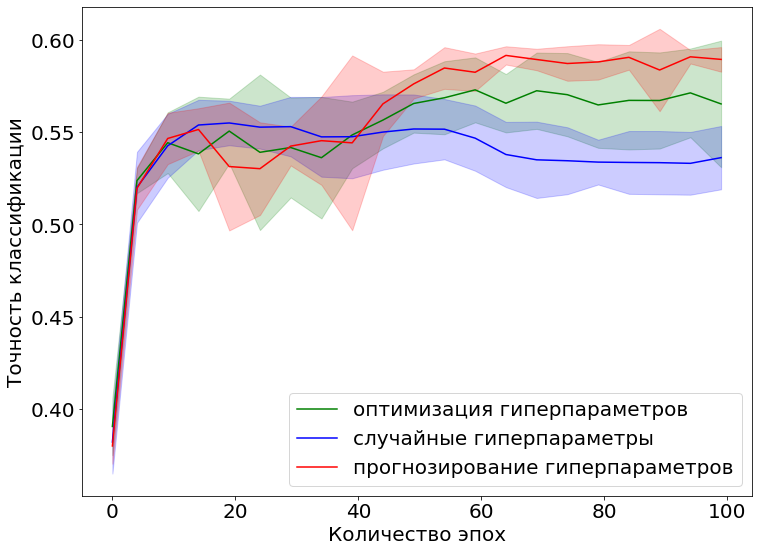

In [11]:
# epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
# acc_b = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
# plt.plot(epoch_b, acc_b.mean(1), '-', color='red', label='без дистилляции')
# plt.fill_between(epoch_b, acc_b.mean(1)-acc_b.std(1), acc_b.mean(1)+acc_b.std(1), alpha=0.2, color='red')

# epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
# acc_d = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
# plt.plot(epoch_d, acc_d.mean(1), '-', color='blue', label='оптимальные гипепараметры')
# plt.fill_between(epoch_d, acc_d.mean(1)-acc_d.std(1), acc_d.mean(1)+acc_d.std(1), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_h[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, acc_h.mean(1), '-', color='green', label='оптимизация гиперпараметров')
plt.fill_between(epoch_h, acc_h.mean(1)-acc_h.std(1), acc_h.mean(1)+acc_h.std(1), alpha=0.2, color='green')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, acc_dr.mean(1), '-', color='blue', label='случайные гиперпараметры')
plt.fill_between(epoch_dr, acc_dr.mean(1)-acc_dr.std(1), acc_dr.mean(1)+acc_dr.std(1), alpha=0.2, color='blue')

epoch_s = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_s[2]['results']))])
acc_s = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_s[0]['results'])) for subdata in data_s]).reshape(epoch_s.shape[0], -1)
plt.plot(epoch_s, acc_s.mean(1), '-', color='red', label='прогнозирование гиперпараметров')
plt.fill_between(epoch_s, acc_s.mean(1)-acc_s.std(1), acc_s.mean(1)+acc_s.std(1), alpha=0.2, color='red')


plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc_17.pdf')

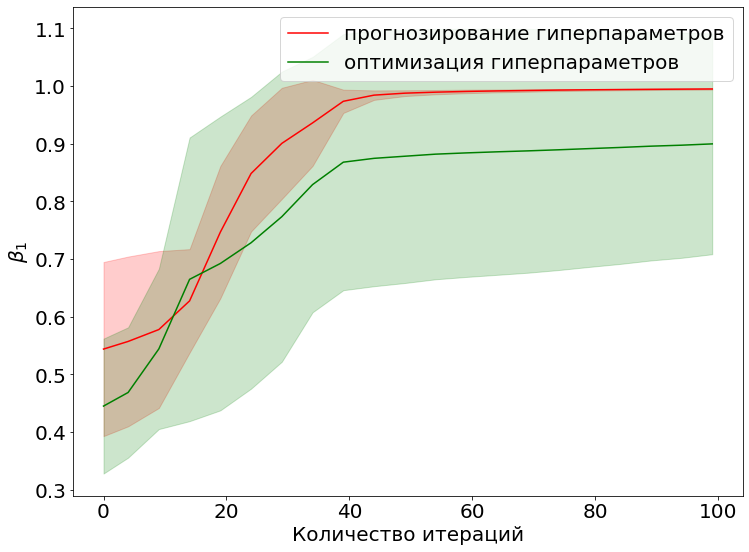

In [15]:
def plot_data_params(data, s, label, color):
    e = np.array([data[2]['results'][i]['epoch'] for i in range(len(data[2]['results']))])
    par = np.array([subdata['results'][i][s] for i in range(len(data[0]['results'])) for subdata in data]).reshape(e.shape[0], -1)
#     par = np.array([data[2]['results'][i][s] for i in range(len(data[2]['results']))])
#     par = []
#     for subdata in data:
#         tmp = [subdata['results'][i][s] for i in range(len(subdata['results']))]
#         par.append(tmp)
#     par = np.array(par).reshape(e.shape[0], -1)
    plt.plot(e, par.mean(1), '-', color=color, label=label)
    plt.fill_between(e, par.mean(1)-par.std(1), par.mean(1)+par.std(1), alpha=0.2, color=color)

plot_data_params(data_s, 'beta1', 'прогнозирование гиперпараметров', 'red')
#plot_data_params(data_dr, 'beta1', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'beta1', 'оптимизация гиперпараметров', 'green')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\beta_1$')
# plt.title(r'График зависимости значения $\beta_1$ от номера итерации')
plt.legend()
plt.savefig('beta1_iter2.pdf')
plt.show()

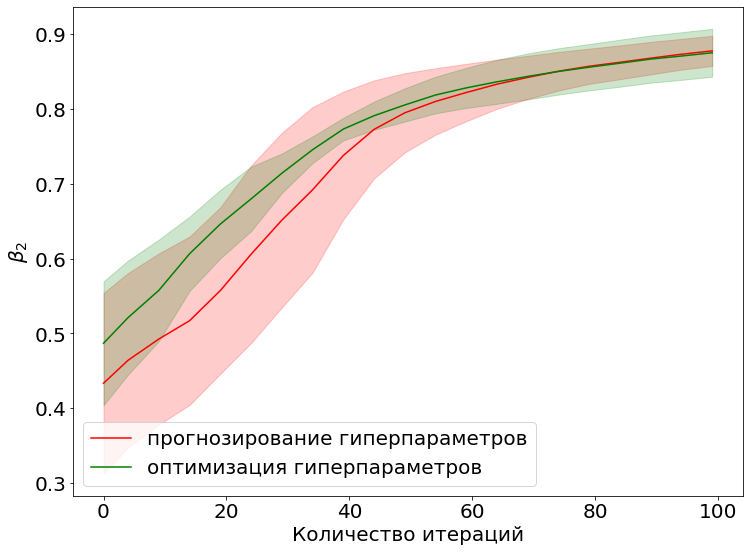

In [16]:
plot_data_params(data_s, 'beta2', 'прогнозирование гиперпараметров', 'red')
#plot_data_params(data_dr, 'beta2', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'beta2', 'оптимизация гиперпараметров', 'green')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\beta_2$')
# plt.title(r'График зависимости значения $\beta_2$ от номера итерации')
plt.legend()
plt.savefig('beta2_iter2.pdf')
plt.show()

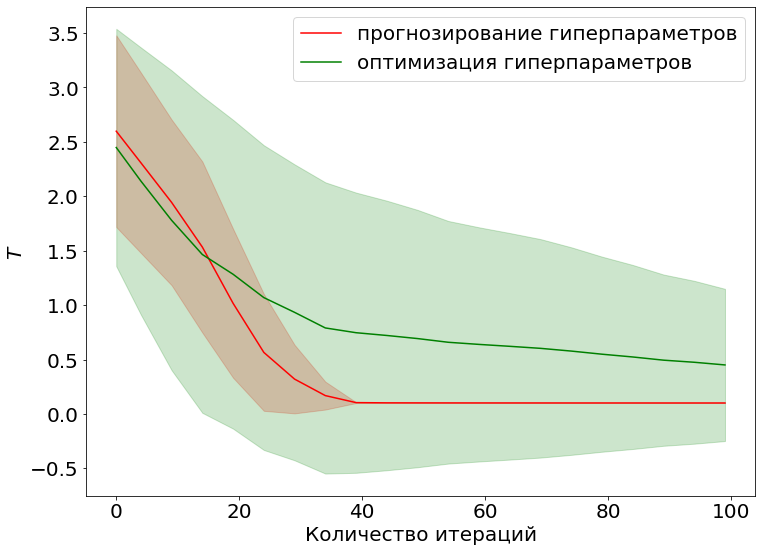

In [17]:
plot_data_params(data_s, 'temp', 'прогнозирование гиперпараметров', 'red')
#plot_data_params(data_dr, 'temp', 'случайные гиперпараметров', 'blue')
plot_data_params(data_h, 'temp', 'оптимизация гиперпараметров', 'green')
plt.xlabel('Количество итераций')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('temp_iter2.pdf')
plt.show()

-----------------

In [ ]:
with open("exp8_dist_h_b2_optim.jsonl", "r") as read_file:
    data_l = [json.loads(line) for line in read_file]
with open("exp9_dist_h_b2_optim.jsonl", "r") as read_file:
    data_q = [json.loads(line) for line in read_file]
with open("exp10_dist_h_b2_optim.jsonl", "r") as read_file:
    data_c = [json.loads(line) for line in read_file]

epoch_l = np.array([data_l[2]['results'][i]['epoch'] for i in range(len(data_l[2]['results']))])
acc_l = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_l[0]['results'])) for subdata in data_l]).reshape(epoch_l.shape[0], -1)
plt.plot(epoch_l[0:11], acc_l[0:11].mean(1), '-', color='red', label='linear')
plt.fill_between(epoch_l[0:11], acc_l[0:11].mean(1)-acc_l[0:11].std(1), acc_l[0:11].mean(1)+acc_l[0:11].std(1), alpha=0.2, color='red')

epoch_q = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_q[2]['results']))])
acc_q = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_q[0]['results'])) for subdata in data_q]).reshape(epoch_q.shape[0], -1)
plt.plot(epoch_q, acc_q.mean(1), '-', color='blue', label='quadratic')
plt.fill_between(epoch_q, acc_q.mean(1)-acc_q.std(1), acc_q.mean(1)+acc_q.std(1), alpha=0.2, color='blue')

epoch_c = np.array([data_c[2]['results'][i]['epoch'] for i in range(len(data_c[2]['results']))])
acc_c = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_c[0]['results'])) for subdata in data_c]).reshape(epoch_c.shape[0], -1)
plt.plot(epoch_c, acc_c.mean(1), '-', color='green', label='cubic')
plt.fill_between(epoch_c, acc_c.mean(1)-acc_c.std(1), acc_c.mean(1)+acc_c.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc_splines.pdf')

In [ ]:
with open("exp11_dist_h_b2_optim.jsonl", "r") as read_file:
    data_5 = [json.loads(line) for line in read_file]
with open("exp12_dist_h_b2_optim.jsonl", "r") as read_file:
    data_2 = [json.loads(line) for line in read_file]
with open("exp13_dist_h_b2_optim.jsonl", "r") as read_file:
    data_3 = [json.loads(line) for line in read_file]
with open("exp14_dist_h_b2_optim.jsonl", "r") as read_file:
    data_10 = [json.loads(line) for line in read_file]

def plot_data(data, label, color):
    epoch = np.array([data[2]['results'][i]['epoch'] for i in range(len(data[2]['results']))])
    acc = np.array([subdata['results'][i]['accuracy'] for i in range(len(data[0]['results'])) for subdata in data]).reshape(epoch.shape[0], -1)
    plt.plot(epoch, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(epoch, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)
    
# epoch_2 = np.array([data_2[2]['results'][i]['epoch'] for i in range(len(data_2[2]['results']))])
# acc_2 = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_l[0]['results'])) for subdata in data_l]).reshape(epoch_l.shape[0], -1)
# plt.plot(epoch_l[0:11], acc_l[0:11].mean(1), '-', color='red', label='linear')
# plt.fill_between(epoch_l[0:11], acc_l[0:11].mean(1)-acc_l[0:11].std(1), acc_l[0:11].mean(1)+acc_l[0:11].std(1), alpha=0.2, color='red')

# epoch_q = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_q[2]['results']))])
# acc_q = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_q[0]['results'])) for subdata in data_q]).reshape(epoch_q.shape[0], -1)
# plt.plot(epoch_q, acc_q.mean(1), '-', color='blue', label='quadratic')
# plt.fill_between(epoch_q, acc_q.mean(1)-acc_q.std(1), acc_q.mean(1)+acc_q.std(1), alpha=0.2, color='blue')

# epoch_c = np.array([data_c[2]['results'][i]['epoch'] for i in range(len(data_c[2]['results']))])
# acc_c = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_c[0]['results'])) for subdata in data_c]).reshape(epoch_c.shape[0], -1)
# plt.plot(epoch_c, acc_c.mean(1), '-', color='green', label='cubic')
# plt.fill_between(epoch_c, acc_c.mean(1)-acc_c.std(1), acc_c.mean(1)+acc_c.std(1), alpha=0.2, color='green')
plot_data(data_5, '5', 'red')
plot_data(data_2, '2', 'blue')
plot_data(data_3, '3', 'green')
plot_data(data_10, '10', 'black')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc_splines.pdf')